# IMDB project: clustering movies
### by Javier Alonso

This Jupyter Notebook is part of ["My IMDB project"](https://javieralonsoalonso.com/category/my-imdb-project/) and tries to cluster the movies in IMDB and take conclussions out of it

The database was downloaded from IMDB on 2020/05/25 but some days after, they changed all the system for retrieving the data, so we won´t be able to upgrade easily the project with new data.

The results have been posted in my ["My blog"](https://javieralonsoalonso.com/category/my-imdb-project/)

## Table of Contents

1. [Preliminary Wrangling](#Preliminary_Wrangling)<br>
1.a.-[Gathering Data](#Gathering_Data)<br>
1.b.-[Assesing and Cleaning Data](#Assesing_cleaning_data)<br>
1.c.-[Consolidation of Dataframes](#Consolidaion_dataframes)<br>
2. [Machine Learning Algorithm](#MLA)<br>
3.a.-[Data preparation](#Data_preparation)<br>
3.b.-[Algorithm Selection](#Alg_Selection)<br>

## <a class="anchor" id="Preliminary_Wrangling">Part 1: Preliminary Wrangling

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import time

%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler


from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import uniform as sp_rand
from scipy.stats import uniform as sp_randFloat
from scipy.stats import uniform as sp_randInt
from scipy.stats import uniform as sp_random

from sklearn.cluster import KMeans
from sklearn import datasets, cluster
from scipy.cluster.hierarchy import dendrogram, ward, single
from sklearn import datasets

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import datasets, mixture

### <a class="anchor" id="Gathering_Data"> 1.a.- Gathering Data

In this section we´ll gather data from the precleaned dataset for the EDA

In [5]:
df_movies = pd.read_csv('IMDB_clean_movies.csv')
df_movies.shape

(221748, 12)

A view of the dataframe

In [6]:
df_movies.head(5)

,idMovie,originalTitle,Year,Minutes,Genres,averageRating,numVotes,decade,director,actors,actress,writers
0,tt0000009,Miss Jerry,1894,45,Romance,5.9,153,1890,Alexander Black,"William Courtenay,Chauncey Depew",Blanche Bayliss,Not available
1,tt0000147,The Corbett-Fitzsimmons Fight,1897,20,"Documentary,News,Sport",5.2,346,1890,Enoch J. Rector,Not available,Not available,Not available
2,tt0000335,Soldiers of the Cross,1900,91,"Biography,Drama",6.1,40,1900,"Herbert Booth,Joseph Perry","Harold Graham,Mr. Graham,John Jones,Orrie Perr...",Beatrice Day,Not available
3,tt0000502,Bohemios,1905,100,No available,3.8,6,1900,Ricardo de Baños,"Antonio del Pozo,El Mochuelo",Not available,"Marguerite Thévenard,Bleuette Bernon"
4,tt0000574,The Story of the Kelly Gang,1906,70,"Biography,Crime,Drama",6.1,574,1900,Charles Tait,"John Tait,Norman Campbell","Elizabeth Tait,Bella Cola",Not available


### <a class="anchor" id="Assesing_cleaning_data"> 1.b.- Asessing and cleaning data

Now, we´re going to assess the dataframe visually and programmatically for quality and tidiness issues, and do the cleaning of these issues

First thing we do a copy of my dataframe


In [7]:
movies = df_movies.copy()

In [8]:
movies.head()

,idMovie,originalTitle,Year,Minutes,Genres,averageRating,numVotes,decade,director,actors,actress,writers
0,tt0000009,Miss Jerry,1894,45,Romance,5.9,153,1890,Alexander Black,"William Courtenay,Chauncey Depew",Blanche Bayliss,Not available
1,tt0000147,The Corbett-Fitzsimmons Fight,1897,20,"Documentary,News,Sport",5.2,346,1890,Enoch J. Rector,Not available,Not available,Not available
2,tt0000335,Soldiers of the Cross,1900,91,"Biography,Drama",6.1,40,1900,"Herbert Booth,Joseph Perry","Harold Graham,Mr. Graham,John Jones,Orrie Perr...",Beatrice Day,Not available
3,tt0000502,Bohemios,1905,100,No available,3.8,6,1900,Ricardo de Baños,"Antonio del Pozo,El Mochuelo",Not available,"Marguerite Thévenard,Bleuette Bernon"
4,tt0000574,The Story of the Kelly Gang,1906,70,"Biography,Crime,Drama",6.1,574,1900,Charles Tait,"John Tait,Norman Campbell","Elizabeth Tait,Bella Cola",Not available


#### Keeping movies with more than 1000 votes

For clustering we are going to get the movies with more than 1.000 votes

In [9]:
movies.describe()

,Year,Minutes,averageRating,numVotes,decade
count,221748.000000,221748.000000,221748.000000,2.217480e+05,221748.000000
mean,1990.273035,94.930047,6.048698,3.667128e+03,1985.555541
std,26.151198,34.030400,1.305295,3.315393e+04,26.066786
min,1894.000000,1.000000,1.000000,5.000000e+00,1890.000000
25%,1973.000000,85.000000,5.300000,1.500000e+01,1970.000000
50%,1999.000000,91.000000,6.200000,5.600000e+01,1990.000000
75%,2012.000000,102.000000,6.900000,3.080000e+02,2010.000000
max,2020.000000,10062.000000,10.000000,2.242140e+06,2020.000000


In [10]:
len(movies)

221748

In [11]:
movies = movies[movies.numVotes>1000]

In [12]:
len(movies)

30381

So we will cluster 30.381 movies

#### Incorrect datatypes

Decade should be string. We change the datatype

In [13]:
movies.decade = movies.decade.astype(str)

In [14]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30381 entries, 63 to 221712
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   idMovie        30381 non-null  object 
 1   originalTitle  30381 non-null  object 
 2   Year           30381 non-null  int64  
 3   Minutes        30381 non-null  int64  
 4   Genres         30381 non-null  object 
 5   averageRating  30381 non-null  float64
 6   numVotes       30381 non-null  int64  
 7   decade         30381 non-null  object 
 8   director       30381 non-null  object 
 9   actors         30381 non-null  object 
 10  actress        30379 non-null  object 
 11  writers        30381 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 3.0+ MB


#### Deleting columns

**Director, actors, actress and writers column** as we will get them from other dataframe

In [15]:
movies = movies.drop(['director'], axis=1)
movies = movies.drop(['actors'], axis=1)
movies = movies.drop(['actress'], axis=1)
movies = movies.drop(['writers'], axis=1)

In [16]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30381 entries, 63 to 221712
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   idMovie        30381 non-null  object 
 1   originalTitle  30381 non-null  object 
 2   Year           30381 non-null  int64  
 3   Minutes        30381 non-null  int64  
 4   Genres         30381 non-null  object 
 5   averageRating  30381 non-null  float64
 6   numVotes       30381 non-null  int64  
 7   decade         30381 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 2.1+ MB


#### Getting the crews info

In [17]:
#We read data of the crew
df_principals = pd.read_csv("title.principals.tsv",  sep="\t", na_values=["\\N","nan"])
df_names = pd.read_csv("name.basics.tsv", sep="\t", na_values=["\\N","nan"])

In [18]:
df_names.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899.0,1987.0,"soundtrack,actor,miscellaneous","tt0050419,tt0072308,tt0053137,tt0043044"
1,nm0000002,Lauren Bacall,1924.0,2014.0,"actress,soundtrack","tt0071877,tt0037382,tt0038355,tt0117057"
2,nm0000003,Brigitte Bardot,1934.0,NaN,"actress,soundtrack,producer","tt0054452,tt0059956,tt0057345,tt0049189"
3,nm0000004,John Belushi,1949.0,1982.0,"actor,soundtrack,writer","tt0080455,tt0078723,tt0072562,tt0077975"
4,nm0000005,Ingmar Bergman,1918.0,2007.0,"writer,director,actor","tt0083922,tt0060827,tt0050986,tt0050976"


In [19]:
#in principals we just keep some columns and only the actor, actress, director and writer
principals = df_principals[['tconst','ordering','nconst','category']]
principals = principals[principals.category.isin(['actor','actress', 'director','writer'])]

In [20]:
#We keep the principal of each category, by the ordering field
principals2 = principals.groupby(["tconst", "category"])['ordering'].min().reset_index()
crew = pd.merge(principals2, principals, left_on = ['tconst','category','ordering'], right_on = ['tconst','category','ordering'], how = 'left')

In [21]:
#We get the name of the person
crew = pd.merge(crew, df_names[['nconst','primaryName']], left_on = 'nconst', right_on = 'nconst', how = 'left')
#I just keep the fields I need
crew = crew[['tconst','category', 'primaryName']]

In [22]:
crew.head()

,tconst,category,primaryName
0,tt0000001,director,William K.L. Dickson
1,tt0000002,director,Émile Reynaud
2,tt0000003,director,Émile Reynaud
3,tt0000004,director,Émile Reynaud
4,tt0000005,actor,Charles Kayser


In [23]:
#We pivot the table
crew = crew.pivot_table(values='primaryName', index=['tconst'],
                    columns=['category'], aggfunc='first').reset_index()

In [24]:
crew.head()

category,tconst,actor,actress,director,writer
0,tt0000001,NaN,NaN,William K.L. Dickson,NaN
1,tt0000002,NaN,NaN,Émile Reynaud,NaN
2,tt0000003,NaN,NaN,Émile Reynaud,NaN
3,tt0000004,NaN,NaN,Émile Reynaud,NaN
4,tt0000005,Charles Kayser,NaN,William K.L. Dickson,NaN


In [25]:
crew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4937749 entries, 0 to 4937748
Data columns (total 5 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   tconst    object
 1   actor     object
 2   actress   object
 3   director  object
 4   writer    object
dtypes: object(5)
memory usage: 188.4+ MB


In [26]:
#I replace NaNs
crew['actor'].fillna('Not available', inplace=True)
crew['actress'].fillna('Not available', inplace=True)
crew['director'].fillna('Not available', inplace=True)
crew['writer'].fillna('Not available', inplace=True)

In [27]:
crew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4937749 entries, 0 to 4937748
Data columns (total 5 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   tconst    object
 1   actor     object
 2   actress   object
 3   director  object
 4   writer    object
dtypes: object(5)
memory usage: 188.4+ MB


In [28]:
crew.head()

category,tconst,actor,actress,director,writer
0,tt0000001,Not available,Not available,William K.L. Dickson,Not available
1,tt0000002,Not available,Not available,Émile Reynaud,Not available
2,tt0000003,Not available,Not available,Émile Reynaud,Not available
3,tt0000004,Not available,Not available,Émile Reynaud,Not available
4,tt0000005,Charles Kayser,Not available,William K.L. Dickson,Not available


**Merging the information**

In [29]:
movies = pd.merge(movies, crew, left_on = 'idMovie', right_on = 'tconst', how = 'left')

In [30]:
movies.columns

Index(['idMovie', 'originalTitle', 'Year', 'Minutes', 'Genres',
       'averageRating', 'numVotes', 'decade', 'tconst', 'actor', 'actress',
       'director', 'writer'],
      dtype='object')

In [31]:
len(movies)

30381

In [32]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30381 entries, 0 to 30380
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   idMovie        30381 non-null  object 
 1   originalTitle  30381 non-null  object 
 2   Year           30381 non-null  int64  
 3   Minutes        30381 non-null  int64  
 4   Genres         30381 non-null  object 
 5   averageRating  30381 non-null  float64
 6   numVotes       30381 non-null  int64  
 7   decade         30381 non-null  object 
 8   tconst         30321 non-null  object 
 9   actor          30321 non-null  object 
 10  actress        30321 non-null  object 
 11  director       30321 non-null  object 
 12  writer         30321 non-null  object 
dtypes: float64(1), int64(3), object(9)
memory usage: 3.2+ MB


In [33]:
#We delete the nans
movies = movies.dropna()

**Save the movies database**

In [36]:
movies_resume = movies.copy()

In [37]:
movies_resume = movies.drop(['idMovie'], axis=1)

In [38]:
movies.head()

,idMovie,originalTitle,Year,Minutes,Genres,averageRating,numVotes,decade,tconst,actor,actress,director,writer
0,tt0002130,L'Inferno,1911,68,"Adventure,Drama,Fantasy",7.0,2167,1910,tt0002130,Salvatore Papa,Not available,Francesco Bertolini,Dante Alighieri
1,tt0002844,Fantômas - À l'ombre de la guillotine,1913,54,"Crime,Drama",7.0,1915,1910,tt0002844,René Navarre,Renée Carl,Louis Feuillade,Marcel Allain
2,tt0003037,Juve contre Fantômas,1913,61,"Crime,Drama",7.0,1334,1910,tt0003037,René Navarre,Renée Carl,Louis Feuillade,Marcel Allain
3,tt0003165,Le mort qui tue,1913,90,"Crime,Drama,Mystery",7.0,1033,1910,tt0003165,René Navarre,Not available,Louis Feuillade,Marcel Allain
4,tt0003419,Der Student von Prag,1913,85,"Drama,Fantasy,Horror",6.5,1735,1910,tt0003419,Paul Wegener,Grete Berger,Stellan Rye,Hanns Heinz Ewers


In [39]:
movies_resume.shape

(30321, 12)

In [40]:
movies_resume.to_csv('IMDB_movies_clasif_resume.csv', index = False)

**Keeping only the important crew**

In [41]:
movies.head()

,idMovie,originalTitle,Year,Minutes,Genres,averageRating,numVotes,decade,tconst,actor,actress,director,writer
0,tt0002130,L'Inferno,1911,68,"Adventure,Drama,Fantasy",7.0,2167,1910,tt0002130,Salvatore Papa,Not available,Francesco Bertolini,Dante Alighieri
1,tt0002844,Fantômas - À l'ombre de la guillotine,1913,54,"Crime,Drama",7.0,1915,1910,tt0002844,René Navarre,Renée Carl,Louis Feuillade,Marcel Allain
2,tt0003037,Juve contre Fantômas,1913,61,"Crime,Drama",7.0,1334,1910,tt0003037,René Navarre,Renée Carl,Louis Feuillade,Marcel Allain
3,tt0003165,Le mort qui tue,1913,90,"Crime,Drama,Mystery",7.0,1033,1910,tt0003165,René Navarre,Not available,Louis Feuillade,Marcel Allain
4,tt0003419,Der Student von Prag,1913,85,"Drama,Fantasy,Horror",6.5,1735,1910,tt0003419,Paul Wegener,Grete Berger,Stellan Rye,Hanns Heinz Ewers


In [42]:
movies[['originalTitle','Year','Minutes','Genres','director','actor','actress','writer','numVotes','averageRating']].sort_values(by ='numVotes', ascending = False).head()

,originalTitle,Year,Minutes,Genres,director,actor,actress,writer,numVotes,averageRating
9767,The Shawshank Redemption,1994,142,Drama,Frank Darabont,Tim Robbins,Not available,Stephen King,2242140,9.3
16735,The Dark Knight,2008,152,"Action,Crime,Drama",Christopher Nolan,Christian Bale,Not available,Jonathan Nolan,2211374,9.0
20383,Inception,2010,148,"Action,Adventure,Sci-Fi",Christopher Nolan,Leonardo DiCaprio,Ellen Page,Not available,1965288,8.8
11418,Fight Club,1999,139,Drama,David Fincher,Brad Pitt,Not available,Chuck Palahniuk,1783906,8.8
9734,Pulp Fiction,1994,154,"Crime,Drama",Quentin Tarantino,John Travolta,Uma Thurman,Roger Avary,1756398,8.9


In [43]:
n_actors = len(movies.actor.unique())
n_actress = len(movies.actress.unique())
n_director = len(movies.director.unique())
n_writer = len(movies.writer.unique())

In [44]:
print("There are", n_actors, "different actors,", n_actress,"different actresses,", n_director," different directors and", n_writer,"different writers")

There are 11019 different actors, 11082 different actresses, 11581  different directors and 14034 different writers


With these numbers is impossible to create different dummies for each of them so we are going to delimit them to 1000 for each category, that will be the ones that are present in more movies

In [45]:
n = 1000
top_actors = movies[movies.actor != 'Not available'].groupby("actor")['idMovie'].count()
top_actors = top_actors.to_frame().reset_index().sort_values(by = 'idMovie', ascending = False)['actor'].head(n).to_list()
top_actress = movies[movies.actress != 'Not available'].groupby("actress")['idMovie'].count()
top_actress = top_actress.to_frame().reset_index().sort_values(by = 'idMovie', ascending = False)['actress'].head(n).to_list()
top_director = movies[movies.director != 'Not available'].groupby("director")['idMovie'].count()
top_director = top_director.to_frame().reset_index().sort_values(by = 'idMovie', ascending = False)['director'].head(n).to_list()
top_writer = movies[movies.writer != 'Not available'].groupby("writer")['idMovie'].count()
top_writer = top_writer.to_frame().reset_index().sort_values(by = 'idMovie', ascending = False)['writer'].head(n).to_list()

In [46]:
movies.actor.value_counts()

Not available       1073
Amitabh Bachchan      78
Akshay Kumar          75
John Wayne            74
Nicolas Cage          72
                    ... 
Milan Maric            1
Wyatt Cenac            1
Adi Afendi             1
Albert Tsai            1
Mark Kelly             1
Name: actor, Length: 11019, dtype: int64

In [47]:
movies.actor = movies.actor.apply(lambda x: x if x in top_actors else "Not available")
movies.actress = movies.actress.apply(lambda x: x if x in top_actress else "Not available")
movies.director = movies.director.apply(lambda x: x if x in top_director else "Not available")
movies.writer = movies.writer.apply(lambda x: x if x in top_writer else "Not available")

In [48]:
movies.actor.value_counts()

Not available        16184
Amitabh Bachchan        78
Akshay Kumar            75
John Wayne              74
Nicolas Cage            72
                     ...  
Pierre Niney             6
Isaach De Bankolé        6
Denis Lavant             6
Marcin Dorocinski        6
Antonio Resines          6
Name: actor, Length: 1001, dtype: int64

In [49]:
movies.head()

,idMovie,originalTitle,Year,Minutes,Genres,averageRating,numVotes,decade,tconst,actor,actress,director,writer
0,tt0002130,L'Inferno,1911,68,"Adventure,Drama,Fantasy",7.0,2167,1910,tt0002130,Not available,Not available,Not available,Not available
1,tt0002844,Fantômas - À l'ombre de la guillotine,1913,54,"Crime,Drama",7.0,1915,1910,tt0002844,Not available,Not available,Not available,Marcel Allain
2,tt0003037,Juve contre Fantômas,1913,61,"Crime,Drama",7.0,1334,1910,tt0003037,Not available,Not available,Not available,Marcel Allain
3,tt0003165,Le mort qui tue,1913,90,"Crime,Drama,Mystery",7.0,1033,1910,tt0003165,Not available,Not available,Not available,Marcel Allain
4,tt0003419,Der Student von Prag,1913,85,"Drama,Fantasy,Horror",6.5,1735,1910,tt0003419,Not available,Not available,Not available,Not available


#### Transforming Skewed Continuous Features

In [50]:
movies.skew(axis = 0) 

Year            -1.275377
Minutes          2.978715
averageRating   -0.886239
numVotes         8.870463
decade          -1.291177
dtype: float64

The rating is aprox Symetric and decade is in reality a cathegory, so we don´t mind Skew of both of them.

Number of votes is not going to get into the variables to cluster so we leave it like this.

So, we are going to transform Minutes for reducing Skewness, due to its high level

In [51]:
movies.Minutes = movies.Minutes.apply(lambda x: np.log(x + 1))

The results are really good

In [52]:
movies.skew(axis = 0) 

Year            -1.275377
Minutes          0.724629
averageRating   -0.886239
numVotes         8.870463
decade          -1.291177
dtype: float64

#### Normalizing Numerical Features

In [53]:
movies.describe()

,Year,Minutes,averageRating,numVotes
count,30321.000000,30321.000000,30321.000000,3.032100e+04
mean,1996.255598,4.646812,6.367772,2.599782e+04
std,21.817777,0.190777,1.131042,8.636674e+04
min,1911.000000,3.828641,1.000000,1.001000e+03
25%,1986.000000,4.521789,5.700000,1.704000e+03
50%,2004.000000,4.615121,6.500000,3.542000e+03
75%,2013.000000,4.744932,7.200000,1.230100e+04
max,2020.000000,6.593045,9.500000,2.242140e+06


In [54]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['Minutes','Year']

movies[numerical] = scaler.fit_transform(movies[numerical])

In [55]:
movies.describe()

,Year,Minutes,averageRating,numVotes
count,30321.000000,30321.000000,30321.000000,3.032100e+04
mean,0.782161,0.295966,6.367772,2.599782e+04
std,0.200163,0.069012,1.131042,8.636674e+04
min,0.000000,0.000000,1.000000,1.001000e+03
25%,0.688073,0.250740,5.700000,1.704000e+03
50%,0.853211,0.284502,6.500000,3.542000e+03
75%,0.935780,0.331461,7.200000,1.230100e+04
max,1.000000,1.000000,9.500000,2.242140e+06


In [56]:
movies.head()

,idMovie,originalTitle,Year,Minutes,Genres,averageRating,numVotes,decade,tconst,actor,actress,director,writer
0,tt0002130,L'Inferno,0.000000,0.146674,"Adventure,Drama,Fantasy",7.0,2167,1910,tt0002130,Not available,Not available,Not available,Not available
1,tt0002844,Fantômas - À l'ombre de la guillotine,0.018349,0.064640,"Crime,Drama",7.0,1915,1910,tt0002844,Not available,Not available,Not available,Marcel Allain
2,tt0003037,Juve contre Fantômas,0.018349,0.107977,"Crime,Drama",7.0,1334,1910,tt0003037,Not available,Not available,Not available,Marcel Allain
3,tt0003165,Le mort qui tue,0.018349,0.246787,"Crime,Drama,Mystery",7.0,1033,1910,tt0003165,Not available,Not available,Not available,Marcel Allain
4,tt0003419,Der Student von Prag,0.018349,0.226344,"Drama,Fantasy,Horror",6.5,1735,1910,tt0003419,Not available,Not available,Not available,Not available


### Creating Dummy columns

**Genres**

In [57]:
movies = movies.join(movies.Genres.str.get_dummies(sep=',').add_prefix('genre_'))
movies = movies.drop(['Genres'], axis=1)

In [58]:
movies = movies.drop(['genre_No available'], axis=1)
movies = movies.drop(['tconst'], axis=1)

**Rest of dummies**

In [59]:
movies_final = pd.get_dummies(movies, prefix=['dec_','actor_','actress_','dir_','writ_'], columns=['decade','actor','actress','director','writer'])

In [60]:
movies_final.head()

,idMovie,originalTitle,Year,Minutes,averageRating,numVotes,genre_Action,genre_Adult,genre_Adventure,genre_Animation,...,writ__William Wheeler,writ__Yavuz Turgul,writ__Yolanda García Serrano,writ__Youssef Maaty,writ__Yunus Sajawal,writ__Yuriy Arabov,writ__Yuriy Korotkov,writ__Zak Penn,writ__Émile Zola,writ__Éric Besnard
0,tt0002130,L'Inferno,0.000000,0.146674,7.0,2167,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,tt0002844,Fantômas - À l'ombre de la guillotine,0.018349,0.064640,7.0,1915,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0003037,Juve contre Fantômas,0.018349,0.107977,7.0,1334,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0003165,Le mort qui tue,0.018349,0.246787,7.0,1033,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0003419,Der Student von Prag,0.018349,0.226344,6.5,1735,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
movies_final.shape

(30321, 4046)

**Creation of top voted and top rated dataframes**

Average rating higher than 8 and votes > 20.000

In [62]:
movies_final.describe()

,Year,Minutes,averageRating,numVotes,genre_Action,genre_Adult,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,...,writ__William Wheeler,writ__Yavuz Turgul,writ__Yolanda García Serrano,writ__Youssef Maaty,writ__Yunus Sajawal,writ__Yuriy Arabov,writ__Yuriy Korotkov,writ__Zak Penn,writ__Émile Zola,writ__Éric Besnard
count,30321.000000,30321.000000,30321.000000,3.032100e+04,30321.000000,30321.000000,30321.000000,30321.000000,30321.000000,30321.000000,...,30321.000000,30321.000000,30321.000000,30321.000000,30321.000000,30321.000000,30321.000000,30321.000000,30321.000000,30321.000000
mean,0.782161,0.295966,6.367772,2.599782e+04,0.186241,0.000033,0.115135,0.032618,0.053692,0.357739,...,0.000132,0.000231,0.000132,0.000198,0.000231,0.000132,0.000132,0.000198,0.000165,0.000132
std,0.200163,0.069012,1.131042,8.636674e+04,0.389307,0.005743,0.319190,0.177637,0.225413,0.479343,...,0.011485,0.015193,0.011485,0.014066,0.015193,0.011485,0.011485,0.014066,0.012841,0.011485
min,0.000000,0.000000,1.000000,1.001000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.688073,0.250740,5.700000,1.704000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.853211,0.284502,6.500000,3.542000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.935780,0.331461,7.200000,1.230100e+04,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,9.500000,2.242140e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [63]:
movies_final.shape

(30321, 4046)

### <a class="anchor" id="Consolidaion_dataframes"> 1.c.- Consolidation of dataframes

In this section we´re going to consolidate both dataframes into files, that we´ll read for the next sections

In [65]:
movies_final.to_csv('IMDB_movies_clasif_all.csv', index = False)

## <a class="anchor" id="Clustering">Part 2: Clustering movies

### <a class="anchor" id="Data_preparation"> 3.a.- Data preparation
We import the data and fix importation issues

In [236]:
movies = pd.read_csv('IMDB_movies_clasif_all.csv')
movies_resume = pd.read_csv('IMDB_movies_clasif_resume.csv')

In [237]:
movies.shape, movies_resume.shape

((30321, 4046), (30321, 12))

In [238]:
movies = movies.drop(['actor__Not available','dir__Not available','actress__Not available','writ__Not available'], axis=1)

In [239]:
movies.head()

,idMovie,originalTitle,Year,Minutes,averageRating,numVotes,genre_Action,genre_Adult,genre_Adventure,genre_Animation,...,writ__William Wheeler,writ__Yavuz Turgul,writ__Yolanda García Serrano,writ__Youssef Maaty,writ__Yunus Sajawal,writ__Yuriy Arabov,writ__Yuriy Korotkov,writ__Zak Penn,writ__Émile Zola,writ__Éric Besnard
0,tt0002130,L'Inferno,0.000000,0.146674,7.0,2167,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,tt0002844,Fantômas - À l'ombre de la guillotine,0.018349,0.064640,7.0,1915,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0003037,Juve contre Fantômas,0.018349,0.107977,7.0,1334,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0003165,Le mort qui tue,0.018349,0.246787,7.0,1033,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0003419,Der Student von Prag,0.018349,0.226344,6.5,1735,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [240]:
movies1 = movies.copy()
movies1 = movies1[['idMovie','originalTitle','numVotes','averageRating']]

In [241]:
movies1.shape

(30321, 4)

In [242]:
movies2 = movies.copy()
movies2 = movies2.drop(['idMovie','originalTitle','numVotes','averageRating'], axis=1)

In [243]:
movies2.shape

(30321, 4038)

#### Applying PCA

In this section we will apply feature reduction with PCA to the dataset with default values, without fixing the number of components. We will do it over movies2, that hasn´t categorical variables

In [74]:
# Apply PCA to the data.
pca = PCA()
movies_pca = pca.fit_transform(movies2)

In [75]:
column_names = ["Component", "variance", "acumulative_variance"]
variances = pd.DataFrame(columns = column_names)
var_acu = 0
for i in range(len(pca.explained_variance_ratio_)):
    comp = i +1 
    var = pca.explained_variance_ratio_[i]
    var_acu = var_acu +  var
    variances.loc[i] = [comp, var, var_acu]

Now we plot the acumulative and individual variance ratio versus the number oc principal components used

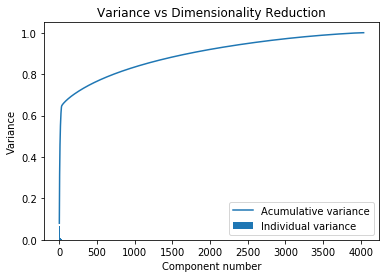

In [76]:
plt.plot(variances.Component, variances.acumulative_variance);
plt.bar(variances.Component, variances.variance);
plt.xlabel('Component number') 
plt.ylabel('Variance');
plt.legend(['Acumulative variance','Individual variance']);
plt.title('Variance vs Dimensionality Reduction');

In [77]:
variances.head()

,Component,variance,acumulative_variance
0,1.0,0.080078,0.080078
1,2.0,0.078765,0.158843
2,3.0,0.065919,0.224762
3,4.0,0.046382,0.271144
4,5.0,0.044717,0.315861


For clustering it´s not needed a very detailed info so we´ve decided to keep 80% of the information, so we will use 724 variables

In [78]:
for i in range(len(variances)):
    if variances.acumulative_variance[i] > 0.80:
        num = i
        var = variances.acumulative_variance[i]
        break
        
print("Using", i, "variables, we can explain", round(var,2), "of the variability in the original data.")

Using 724 variables, we can explain 0.8 of the variability in the original data.


In [244]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 724)


In [245]:
movies_pca = pca.fit_transform(movies2)
movies_pca_end = pd.DataFrame(movies_pca)
movies_pca_end.head()

,0,1,2,3,4,5,6,7,8,9,...,714,715,716,717,718,719,720,721,722,723
0,-0.027862,-0.421529,0.193176,0.566599,0.019732,-0.659068,-0.514126,-0.165844,-0.050951,-0.453025,...,0.007870,-0.014651,0.011318,-0.005863,0.006596,0.008784,-0.008226,-0.026114,-0.001098,-0.010793
1,-0.172138,-0.648476,0.255416,0.556027,-0.042785,0.540410,-0.132202,-0.533486,-0.249872,-0.097743,...,0.010598,-0.020022,0.016426,-0.007400,0.010868,0.012866,-0.011054,-0.037153,-0.004002,-0.015466
2,-0.172871,-0.649571,0.255128,0.556245,-0.044151,0.539981,-0.131527,-0.532884,-0.249288,-0.097743,...,0.010937,-0.019937,0.016175,-0.007223,0.011008,0.012975,-0.010946,-0.036902,-0.004232,-0.015263
3,-0.237497,-0.647531,0.359403,0.486935,0.109984,0.670587,-0.135438,-0.561772,-0.366275,-0.069940,...,0.011153,-0.020236,0.015537,-0.006474,0.011003,0.012916,-0.011564,-0.036221,-0.005816,-0.014848
4,-0.129304,-0.405174,0.295598,0.243887,0.707957,-0.266129,-0.479822,-0.123669,-0.114133,0.510189,...,0.008181,-0.013827,0.011490,-0.005888,0.007007,0.009739,-0.007190,-0.025576,-0.001775,-0.009978


#### Interpreting Principal Components

Now that we have our transformed principal components, we are going to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

In [81]:
def pc_indexes(df, pca, n):
    """
    Gives the 10 most important variables with its weights in the component n after applying pca to de dataframe df
    
    INPUT: df (dataframe), pca (transformation applied), n(principal component to analyze)
    OUTPUT: list of the top 10 variables and their weights
    """

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = df.keys())
    components.index = dimensions
    df_comp = components.iloc[n-1].to_frame()
    df_comp["Abs_value"] = df_comp.abs()
    df_comp = df_comp.sort_values(by='Abs_value', ascending = False)
    df_comp = df_comp[df_comp.columns[0]].head(10)
    return df_comp


In [82]:
# Get weights for the first principal component
pc_indexes(movies2, pca, 1)

dec__2010        -0.6011
genre_Comedy      0.5590
dec__2000         0.3353
genre_Drama      -0.3044
genre_Thriller   -0.1902
genre_Romance     0.1513
Year             -0.1185
dec__1990         0.0969
genre_Action     -0.0868
genre_Crime      -0.0778
Name: Dimension 1, dtype: float64

In [83]:
pc_indexes(movies2, pca, 2)

genre_Drama       -0.7441
dec__2010          0.3789
genre_Comedy       0.2814
dec__2000         -0.2508
genre_Action       0.1974
genre_Romance     -0.1913
genre_Horror       0.1618
genre_Adventure    0.1449
genre_Thriller     0.0903
Year               0.0839
Name: Dimension 2, dtype: float64

In [84]:
pc_indexes(movies2, pca, 3)

genre_Comedy      -0.5154
dec__2010         -0.4208
genre_Romance     -0.3144
dec__2000          0.3069
genre_Action       0.2957
genre_Thriller     0.2943
genre_Drama       -0.2577
genre_Horror       0.2135
genre_Crime        0.1938
genre_Adventure    0.1093
Name: Dimension 3, dtype: float64

In [85]:
pc_indexes(movies2, pca, 4)

dec__2000         -0.6859
dec__1990          0.3893
dec__2010         -0.2851
Year              -0.2635
genre_Action       0.2118
dec__1980          0.1816
genre_Adventure    0.1600
genre_Crime        0.1595
genre_Horror      -0.1583
genre_Thriller    -0.1449
Name: Dimension 4, dtype: float64

We can see that the first 4 principal components are based on the genre and when it was filmed (different decades or year)

**consolidation of dataframes**

In [246]:
movies_pca_end.to_csv('IMDB_movies_clasif_pca_end.csv', index = False)

### <a class="anchor" id="Clust_general"> 3.b.- Clustering database with kmeans

In this section we apply k-means clustering to the dataframe. K-means needs as input the number of clusters to cluster the database, so getting that number will be the first task

    
**How many clusters? The elbow method**    

The elbow method is an easy and fast method to get a aproximate number of optimal clusters.
    
For each number of clusters we get the average distance from each point of the cluster to its centroid and plot it. Where there´s an "elbow" on the plot it´s the optimal number. The elbow is where the plot changes to an almost horizontal line

Execution time: 0.35 minutes
The score for 5 components is 74676.71101493668
Execution time: 0.68 minutes
The score for 25 components is 55635.09317490778
Execution time: 0.86 minutes
The score for 45 components is 47950.7666871577
Execution time: 1.0 minutes
The score for 65 components is 44447.772649420396
Execution time: 1.13 minutes
The score for 75 components is 42783.81892583537
Execution time: 1.14 minutes
The score for 80 components is 42200.31721205062
Execution time: 1.22 minutes
The score for 84 components is 41601.37822665944
Execution time: 1.23 minutes
The score for 88 components is 41178.445129814216
Execution time: 1.24 minutes
The score for 92 components is 40856.122714978505
Execution time: 1.27 minutes
The score for 94 components is 40244.82227578705


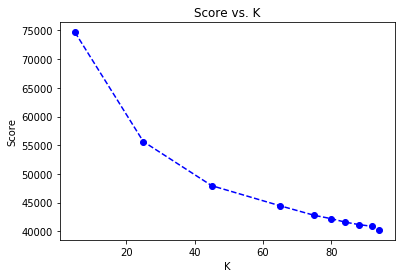

In [16]:
scores = []
centers =  [5,25, 45, 65, 75, 80, 84, 88, 92, 94]

for center in centers:
    scores.append(get_score(movies_pca_end, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Score');
plt.title('Score vs. K');

It´s really difficult to see where the elbow is located in this plot because the score keeps descending. With the next method we will get the correct number

**How many clusters? The silhouette score**

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. We get the silhouette score of a model averaging the score for each point.

We compare the score for different numbers of clusters, and the maximum score will point the optimal number of clusters

In [14]:
def get_sil_score(data, clusters):
    start_time = time.time()

    kmeans = KMeans(n_clusters= clusters)

    model = kmeans.fit_predict(data)

    score = silhouette_score(movies_pca_end, model)

    exec_time = round((time.time() - start_time)/60,2)
    print("Execution time:",exec_time,"minutes")
    print("The silhouette score for",clusters,"components is", score)
    return score

Execution time: 0.58 minutes
The silhouette score for 5 components is 0.11221454753428117
Execution time: 0.92 minutes
The silhouette score for 25 components is 0.10735301816704844
Execution time: 1.18 minutes
The silhouette score for 45 components is 0.13394250627958132
Execution time: 1.27 minutes
The silhouette score for 65 components is 0.14824705447792325
Execution time: 1.47 minutes
The silhouette score for 75 components is 0.15365814979676296
Execution time: 1.49 minutes
The silhouette score for 80 components is 0.16176677767214853
Execution time: 1.53 minutes
The silhouette score for 84 components is 0.16006049957255056
Execution time: 1.53 minutes
The silhouette score for 88 components is 0.15990938047661665
Execution time: 1.58 minutes
The silhouette score for 92 components is 0.15853870876351087
Execution time: 1.52 minutes
The silhouette score for 94 components is 0.15779382236240785


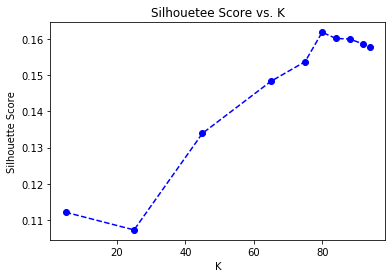

In [13]:
scores = []
centers = [5,25, 45, 65, 75, 80, 84, 88, 92, 94]

for center in centers:
    scores.append(get_sil_score(movies_pca_end, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouetee Score vs. K');

We´ll take 80 clusters as the optimal number

**Fitting the model**

We fit the k-means model to 80 clusters

In [15]:
kmeans = KMeans(n_clusters= 80)
model = kmeans.fit(movies_pca_end)

Let´s analyze the labels predicted

In [30]:
labels = model.predict(movies_pca_end)
labels_movies = pd.DataFrame(labels)
labels_movies.columns = ['kmeans_cluster']

In [31]:
labels_movies.shape

(30321, 1)

Here you have the number of movies in each of the clusters

In [33]:
labels_movies.kmeans_cluster.value_counts()/len(labels_movies)

16    0.060717
12    0.042182
17    0.042050
23    0.033805
32    0.030870
        ...   
76    0.003100
40    0.002935
34    0.002836
46    0.002803
78    0.002342
Name: kmeans_cluster, Length: 80, dtype: float64

**Predicting clusters**

We get the cluster where each movie belongs to

In [35]:
movies_resume = pd.read_csv('IMDB_movies_clasif_resume.csv')

In [36]:
movies_resume.head()

,originalTitle,Year,Minutes,Genres,averageRating,numVotes,decade,tconst,actor,actress,director,writer
0,L'Inferno,1911,68,"Adventure,Drama,Fantasy",7.0,2167,1910,tt0002130,Salvatore Papa,Not available,Francesco Bertolini,Dante Alighieri
1,Fantômas - À l'ombre de la guillotine,1913,54,"Crime,Drama",7.0,1915,1910,tt0002844,René Navarre,Renée Carl,Louis Feuillade,Marcel Allain
2,Juve contre Fantômas,1913,61,"Crime,Drama",7.0,1334,1910,tt0003037,René Navarre,Renée Carl,Louis Feuillade,Marcel Allain
3,Le mort qui tue,1913,90,"Crime,Drama,Mystery",7.0,1033,1910,tt0003165,René Navarre,Not available,Louis Feuillade,Marcel Allain
4,Der Student von Prag,1913,85,"Drama,Fantasy,Horror",6.5,1735,1910,tt0003419,Paul Wegener,Grete Berger,Stellan Rye,Hanns Heinz Ewers


In [37]:
labels_movies.head()

,kmeans_cluster
0,57
1,59
2,59
3,8
4,10


In [38]:
movies_resume.shape, labels_movies.shape

((30321, 12), (30321, 1))

In [39]:
movies_cluster = pd.merge(movies_resume, labels_movies, left_index=True, right_index=True)

In [40]:
# let´s drop some columns
movies_cluster = movies_cluster.drop(['tconst'], axis=1)
movies_cluster = movies_cluster.drop(['decade'], axis=1)

In [43]:
# Let´s change the order of columns
movies_cluster = movies_cluster[['originalTitle','Genres','Year','Minutes','director','actor','actress','writer','numVotes','averageRating', 'kmeans_cluster']]

In [44]:
movies_cluster.head()

,originalTitle,Genres,Year,Minutes,director,actor,actress,writer,numVotes,averageRating,kmeans_cluster
0,L'Inferno,"Adventure,Drama,Fantasy",1911,68,Francesco Bertolini,Salvatore Papa,Not available,Dante Alighieri,2167,7.0,57
1,Fantômas - À l'ombre de la guillotine,"Crime,Drama",1913,54,Louis Feuillade,René Navarre,Renée Carl,Marcel Allain,1915,7.0,59
2,Juve contre Fantômas,"Crime,Drama",1913,61,Louis Feuillade,René Navarre,Renée Carl,Marcel Allain,1334,7.0,59
3,Le mort qui tue,"Crime,Drama,Mystery",1913,90,Louis Feuillade,René Navarre,Not available,Marcel Allain,1033,7.0,8
4,Der Student von Prag,"Drama,Fantasy,Horror",1913,85,Stellan Rye,Paul Wegener,Grete Berger,Hanns Heinz Ewers,1735,6.5,10


**Analyzing clusters**

In k-means we can´t get a description for each cluster but we can see the movies that are nearest to the centroid, that will be the most characteristic element for each cluster. Next, you can see these movies for each of the 25 groups.

In [34]:
from sklearn.metrics import pairwise_distances_argmin_min
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, movies_pca_end)
closest

array([ 9750, 14861, 23690, 26116, 25379, 24824, 25698,  6022, 21581,
       11529,  4188, 17383, 24839, 15245, 24992, 12101, 25158, 16566,
        4628, 17769, 27073, 12592, 15102, 26393, 10489, 24135, 10085,
       18013, 21382,  2369,  3633,  9650, 14903, 24225, 23014, 17080,
       11992,  3582, 18274, 10145,  7325,  8246,  4958, 21252, 21212,
       15931, 12576, 16048, 11879,  7162,   802, 26800, 15997,  7558,
       11895, 26818,  7857,  2228,  4782, 12176, 25729,   619, 16855,
       26261,   269,  5178,  1681,  8229,  6841, 28863,  8755, 29318,
        3416, 11515, 10739,  9839,  2068,  1267, 14468, 24645],
      dtype=int64)

In [45]:
movies_close_centroid = movies_cluster.iloc[closest]

In [46]:
movies_close_centroid

,originalTitle,Genres,Year,Minutes,director,actor,actress,writer,numVotes,averageRating,kmeans_cluster
9750,S.P.Q.R. 2000 e 1/2 anni fa,"Comedy,Fantasy",1994,95,Carlo Vanzina,Christian De Sica,Nadia Rinaldi,Enrico Vanzina,1402,3.5,0
14861,School for Seduction,"Comedy,Drama,Romance",2004,104,Sue Heel,Jake Canuso,Sabina Loddo,Martin Herron,1073,5.1,1
23690,Cuatro lunas,"Drama,Romance",2014,110,Sergio Tovar Velarde,Antonio Velázquez,Not available,Anibal Astorga,3708,7.5,2
26116,Kkeut-kka-ji-gan-da,"Action,Crime,Thriller",2014,111,Seong-hun Kim,Sun-kyun Lee,Not available,Hae-jun Lee,9974,7.2,3
25379,Silsile,"Crime,Drama,Thriller",2014,106,Ozan Açiktan,Tardu Flordun,Nehir Erdogan,Cem Akas,1369,6.6,4
...,...,...,...,...,...,...,...,...,...,...,...
9839,Antonia,"Comedy,Drama",1995,102,Marleen Gorris,Jan Decleir,Willeke van Ammelrooy,Not available,7960,7.4,75
2068,Silver Lode,Western,1954,81,Allan Dwan,John Payne,Lizabeth Scott,Karen DeWolf,1558,6.9,76
1267,Decoy,"Crime,Drama,Film-Noir",1946,76,Jack Bernhard,Edward Norris,Jean Gillie,Nedrick Young,1428,6.8,77
14468,Nightstalker,"Crime,Horror",2002,95,Chris Fisher,Bret Roberts,Roxanne Day,Not available,1089,3.3,78


**Consolidation of clustered movies**

In [47]:
movies_cluster.to_csv('IMDB_movies_clustered.csv', index = False)
movies_close_centroid.to_csv('IMDB_movies_kmeans_clustered_closest.csv', index = False)

In [6]:
movies_cluster = pd.read_csv('IMDB_movies_clustered.csv')

In [7]:
movies_close_centroid = pd.read_csv('IMDB_movies_kmeans_clustered_closest.csv')

**Create the most viewed and the top rated movies dataframes**

Let´s get the movies with percentile higher to 90% of most viewed and rated 

In [8]:
movies_cluster.describe()

,Year,Minutes,numVotes,averageRating,kmeans_cluster
count,30321.000000,30321.000000,3.032100e+04,30321.000000,30321.000000
mean,1996.255598,105.274232,2.599782e+04,6.367772,35.375251
std,21.817777,22.694860,8.636674e+04,1.131042,22.129687
min,1911.000000,45.000000,1.001000e+03,1.000000,0.000000
25%,1986.000000,91.000000,1.704000e+03,5.700000,16.000000
50%,2004.000000,100.000000,3.542000e+03,6.500000,32.000000
75%,2013.000000,114.000000,1.230100e+04,7.200000,54.000000
max,2020.000000,729.000000,2.242140e+06,9.500000,79.000000


In [9]:
movies_cluster.numVotes.quantile(0.9)

54714.0

In [10]:
movies_cluster_views = movies_cluster[movies_cluster.numVotes > 54714]

In [11]:
movies_cluster.averageRating.quantile(0.9)

7.6

In [12]:
movies_cluster_rates = movies_cluster[movies_cluster.averageRating > 7.6]

In [13]:
movies_cluster.shape, movies_cluster_views.shape, movies_cluster_rates.shape

((30321, 11), (3032, 11), (2897, 11))

#### Comparing the three clusterizations

Now that we have clustered the three databases, we are going to compare the results.

Next, you can see the rate of movies belonging to each cluster for the three databases

In [14]:
kmeans_clusters = movies_cluster.groupby(['kmeans_cluster'])['originalTitle'].count() * 100 /len(movies_cluster)

In [15]:
kmeans_clusters = kmeans_clusters.to_frame().reset_index()
kmeans_clusters.columns = ['kmeans_cluster', "%_movies"]

In [16]:
kmeans_clusters['%_top_rated_movies'] = movies_cluster_rates.groupby(['kmeans_cluster'])['originalTitle'].count() * 100 /len(movies_cluster_rates)
kmeans_clusters['%_top_viewed_movies'] = movies_cluster_views.groupby(['kmeans_cluster'])['originalTitle'].count() * 100 /len(movies_cluster_views)

In [19]:
kmeans_clusters

,kmeans_cluster,%_movies,%_top_rated_movies,%_top_viewed_movies
0,0,0.372679,0.276148,0.692612
1,1,1.273045,0.414222,1.583113
2,2,2.338313,1.863997,1.781003
3,3,0.689291,0.448740,0.824538
4,4,0.923452,0.759406,0.989446
...,...,...,...,...
75,75,2.117344,1.829479,1.385224
76,76,0.310016,0.207111,0.065963
77,77,0.587052,0.759406,0.131926
78,78,0.234161,NaN,0.230871


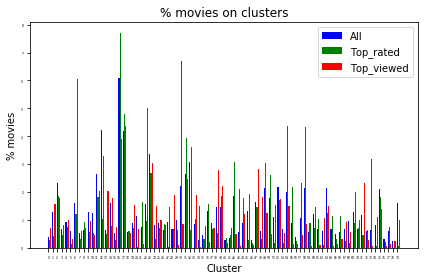

In [34]:
# data to plot
n_groups = 80

# create plot
fig, ax = plt.subplots()
# fig.figsize=(90,15)
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8



rects1 = plt.bar(kmeans_clusters.kmeans_cluster, kmeans_clusters[('%_movies')], bar_width,
color='b',
label='All')

rects2 = plt.bar(kmeans_clusters.kmeans_cluster  + bar_width, kmeans_clusters[('%_top_rated_movies')], bar_width,
color='g',
label='Top_rated')

rects3 = plt.bar(kmeans_clusters.kmeans_cluster  + 2*bar_width, kmeans_clusters[('%_top_viewed_movies')], bar_width,
color='r',
label='Top_viewed')

plt.xlabel('Cluster')
plt.ylabel('% movies')
plt.title('% movies on clusters')
plt.xticks(index , index)

plt.legend()
ax.tick_params(labelsize=3)

plt.savefig('blog/04_clustering/01_Clusters_kmeans.png', format='png', dpi=2400);

plt.tight_layout()
plt.show()



There are so many clusters that is difficult to analyze the plot, but we can see that most of the clusters are balanced between the three categories, although there are clearly unbalance clusters:

- Top rated movies are overrepresented in clusters 16, 30, 54, 58 and 73, where green bars are much higher than the rest

- Top viewed movies are overrepresented in clusters 6 and 22 where red bars are much higher than the rest

Let´s see the 5 clusters where top rated and top viewed movies are most represented

In [40]:
kmeans_clusters.sort_values(by = '%_top_rated_movies', ascending = False).head(5)

,kmeans_cluster,%_movies,%_top_rated_movies,%_top_viewed_movies
16,16,6.071699,7.697618,3.891821
30,30,2.222882,6.696583,0.857520
17,17,4.205006,4.798067,4.353562
54,54,2.001913,4.383845,1.484169
58,58,2.130537,4.349327,0.857520


Let´s see the movies that are the the most characteristic of each cluster.

In [43]:
movies_close_centroid[movies_close_centroid.kmeans_cluster.isin([16,30,17,54,58])]

,originalTitle,Genres,Year,Minutes,director,actor,actress,writer,numVotes,averageRating,kmeans_cluster
16,Le meraviglie,Drama,2014,110,Alice Rohrwacher,Sam Louwyck,Alba Rohrwacher,Not available,4559,6.6,16
17,L'audition,Drama,2005,111,Not available,Luc Picard,Suzanne Clément,Not available,1168,7.1,17
30,Sult,Drama,1966,112,Henning Carlsen,Per Oscarsson,Gunnel Lindblom,Knut Hamsun,2692,7.8,30
54,Zawgat Ragoul Mohem,Drama,1987,115,Mohamed Khan,Ahmed Zaki,Mervat Amin,Not available,1041,7.7,54
58,Kalina krasnaya,Drama,1974,110,Not available,Vasiliy Shukshin,Lidiya Fedoseeva-Shukshina,Not available,1366,7.8,58


They are all dramas with a lenght between 110 and 115 minutes and of different years, being the top clusters from 2014 and 2015.

Let´s do the same with the most viewed.

In [44]:
kmeans_clusters.sort_values(by = '%_top_viewed_movies', ascending = False).head(5)

,kmeans_cluster,%_movies,%_top_rated_movies,%_top_viewed_movies
6,6,1.606148,1.208146,6.035620
22,22,1.553379,0.966517,5.013193
17,17,4.205006,4.798067,4.353562
16,16,6.071699,7.697618,3.891821
32,32,3.086969,0.621332,3.627968


In [45]:
movies_close_centroid[movies_close_centroid.kmeans_cluster.isin([6, 22, 17, 16, 32])]

,originalTitle,Genres,Year,Minutes,director,actor,actress,writer,numVotes,averageRating,kmeans_cluster
6,The Dead Lands,"Action,Adventure",2014,107,Toa Fraser,James Rolleston,Not available,Glenn Standring,4397,6.3,6
16,Le meraviglie,Drama,2014,110,Alice Rohrwacher,Sam Louwyck,Alba Rohrwacher,Not available,4559,6.6,16
17,L'audition,Drama,2005,111,Not available,Luc Picard,Suzanne Clément,Not available,1168,7.1,17
22,The Freediver,"Action,Adventure",2004,95,Not available,Alki David,Camilla Rutherford,Not available,1455,4.8,22
32,Strangers with Candy,Comedy,2005,97,Not available,Stephen Colbert,Amy Sedaris,Mitch Rouse,7744,6.0,32


The most viewed movies are all from this century and they are shorter than the top rated ( between 95 and 110). Here there´s more diversity of genres (Action/Adventure, Drama and Comedy)

### <a class="anchor" id="Clust_general"> 3.b.- Clustering database with hierarchical clustering

In this section we apply hierarchical clustering to the dataframe. We are going to use the ward method, that is the default one.
    
**How many clusters? Creating a Dendrogram**    

A dendrogram is a diagram that shows the hierarchical relationship between objects and it´s used to work out the best way to allocate objects to clusters. We will use it as a first approach to see how many clusters we will use
    
The dendrogram below shows the hierarchical clustering of our IMDB database

In [46]:
movies_pca_end = pd.read_csv('IMDB_movies_clasif_pca_end.csv')

In [263]:
linkage_matrix = ward(movies_pca_end)

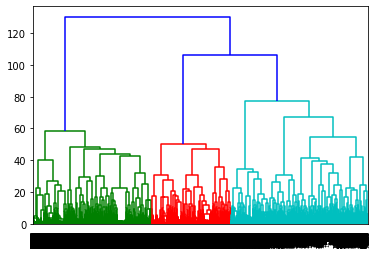

In [267]:
dendrogram(linkage_matrix)
plt.savefig('blog/04_clustering/02_dendrogram.png', format='png', dpi=2400);
plt.show()

We can see there are three main clusters in the database. We´ll get the final number of clusters with the silhouette scores 

**How many clusters? The silhouette score**

Like in kmeans we will apply the silhouette score to different number of clusters to get the one with highest score

In [5]:
def get_sil_score(data, clusters):
    
    start_time = time.time()    
    
    clust = cluster.AgglomerativeClustering(n_clusters = clusters, linkage = 'ward')
    labels = clust.fit_predict(data)

    score = silhouette_score(data, labels)
       

    exec_time = round((time.time() - start_time)/60,2)
    print("Execution time:",exec_time,"minutes")
    print("The silhouette score for",clusters,"components is", score)
    return score

In [6]:
scores = []
centers = [2,3,4, 5, 6]

scores.append(get_sil_score(movies_pca_end, 2))

Execution time: 6.38 minutes
The silhouette score for 2 components is 0.08329248968060182


In [7]:
scores.append(get_sil_score(movies_pca_end, 3))

Execution time: 6.23 minutes
The silhouette score for 3 components is 0.10855043633844245


In [8]:
scores.append(get_sil_score(movies_pca_end, 4))

Execution time: 6.45 minutes
The silhouette score for 4 components is 0.12440616917903613


In [9]:
scores.append(get_sil_score(movies_pca_end, 5))

Execution time: 6.34 minutes
The silhouette score for 5 components is 0.1365754799609799


In [10]:
scores.append(get_sil_score(movies_pca_end, 6))

Execution time: 6.44 minutes
The silhouette score for 6 components is 0.06614171638937598


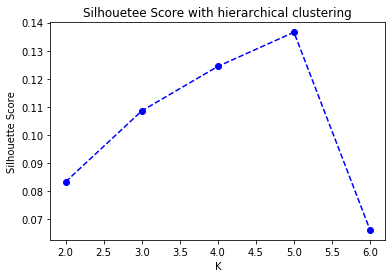

In [12]:
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouetee Score with hierarchical clustering');

5 clusters is the optimal number. Let´s fit the model with this k

**Fitting the model**

We fit the model with clusters

In [42]:
clust = cluster.AgglomerativeClustering(n_clusters = 5, linkage = 'ward')
labels = clust.fit_predict(movies_pca_end)

Let´s analyze the labels predicted

In [43]:
# labels = model.predict(movies_pca_end)
labels_movies = pd.DataFrame(labels)
labels_movies.columns = ['hier_cluster']

In [44]:
labels_movies.shape

(30321, 1)

Here you have the number of movies in each of the clusters

In [45]:
labels_movies.hier_cluster.value_counts()/len(labels_movies)

0    0.355694
2    0.236206
1    0.210778
3    0.112397
4    0.084925
Name: hier_cluster, dtype: float64

**Predicting clusters**

We get the cluster where each movie belongs to

In [46]:
movies_cluster = pd.read_csv('IMDB_movies_clustered.csv')

In [47]:
movies_cluster.head() 

,originalTitle,Genres,Year,Minutes,director,actor,actress,writer,numVotes,averageRating,kmeans_cluster
0,L'Inferno,"Adventure,Drama,Fantasy",1911,68,Francesco Bertolini,Salvatore Papa,Not available,Dante Alighieri,2167,7.0,57
1,Fantômas - À l'ombre de la guillotine,"Crime,Drama",1913,54,Louis Feuillade,René Navarre,Renée Carl,Marcel Allain,1915,7.0,59
2,Juve contre Fantômas,"Crime,Drama",1913,61,Louis Feuillade,René Navarre,Renée Carl,Marcel Allain,1334,7.0,59
3,Le mort qui tue,"Crime,Drama,Mystery",1913,90,Louis Feuillade,René Navarre,Not available,Marcel Allain,1033,7.0,8
4,Der Student von Prag,"Drama,Fantasy,Horror",1913,85,Stellan Rye,Paul Wegener,Grete Berger,Hanns Heinz Ewers,1735,6.5,10


In [48]:
labels_movies.head()

,hier_cluster
0,1
1,1
2,1
3,1
4,1


In [50]:
movies_cluster.shape, labels_movies.shape

((30321, 11), (30321, 1))

In [51]:
movies_cluster = pd.merge(movies_cluster, labels_movies, left_index=True, right_index=True)

In [52]:
movies_cluster.head()

,originalTitle,Genres,Year,Minutes,director,actor,actress,writer,numVotes,averageRating,kmeans_cluster,hier_cluster
0,L'Inferno,"Adventure,Drama,Fantasy",1911,68,Francesco Bertolini,Salvatore Papa,Not available,Dante Alighieri,2167,7.0,57,1
1,Fantômas - À l'ombre de la guillotine,"Crime,Drama",1913,54,Louis Feuillade,René Navarre,Renée Carl,Marcel Allain,1915,7.0,59,1
2,Juve contre Fantômas,"Crime,Drama",1913,61,Louis Feuillade,René Navarre,Renée Carl,Marcel Allain,1334,7.0,59,1
3,Le mort qui tue,"Crime,Drama,Mystery",1913,90,Louis Feuillade,René Navarre,Not available,Marcel Allain,1033,7.0,8,1
4,Der Student von Prag,"Drama,Fantasy,Horror",1913,85,Stellan Rye,Paul Wegener,Grete Berger,Hanns Heinz Ewers,1735,6.5,10,1


In [53]:
movies_cluster.to_csv('IMDB_movies_clustered.csv', index = False)

**Analyzing clusters**

In hierarchical clustering we can´t get a description of the clusters, just know which elements belong to each one

**Create the most viewed and the top rated movies dataframes**

Let´s get the movies with percentile higher to 90% of most viewed and rated 

In [61]:
movies_cluster.head()

,originalTitle,Genres,Year,Minutes,director,actor,actress,writer,numVotes,averageRating,kmeans_cluster,hier_cluster
0,L'Inferno,"Adventure,Drama,Fantasy",1911,68,Francesco Bertolini,Salvatore Papa,Not available,Dante Alighieri,2167,7.0,57,1
1,Fantômas - À l'ombre de la guillotine,"Crime,Drama",1913,54,Louis Feuillade,René Navarre,Renée Carl,Marcel Allain,1915,7.0,59,1
2,Juve contre Fantômas,"Crime,Drama",1913,61,Louis Feuillade,René Navarre,Renée Carl,Marcel Allain,1334,7.0,59,1
3,Le mort qui tue,"Crime,Drama,Mystery",1913,90,Louis Feuillade,René Navarre,Not available,Marcel Allain,1033,7.0,8,1
4,Der Student von Prag,"Drama,Fantasy,Horror",1913,85,Stellan Rye,Paul Wegener,Grete Berger,Hanns Heinz Ewers,1735,6.5,10,1


In [62]:
movies_cluster.describe()

,Year,Minutes,numVotes,averageRating,kmeans_cluster,hier_cluster
count,30321.000000,30321.000000,3.032100e+04,30321.000000,30321.000000,30321.000000
mean,1996.255598,105.274232,2.599782e+04,6.367772,35.375251,1.360080
std,21.817777,22.694860,8.636674e+04,1.131042,22.129687,1.294685
min,1911.000000,45.000000,1.001000e+03,1.000000,0.000000,0.000000
25%,1986.000000,91.000000,1.704000e+03,5.700000,16.000000,0.000000
50%,2004.000000,100.000000,3.542000e+03,6.500000,32.000000,1.000000
75%,2013.000000,114.000000,1.230100e+04,7.200000,54.000000,2.000000
max,2020.000000,729.000000,2.242140e+06,9.500000,79.000000,4.000000


In [60]:
movies_cluster.numVotes.quantile(0.9)

54714.0

In [63]:
movies_cluster_views = movies_cluster[movies_cluster.numVotes > 54714]

In [64]:
movies_cluster.averageRating.quantile(0.9)

7.6

In [65]:
movies_cluster_rates = movies_cluster[movies_cluster.averageRating > 7.6]

In [66]:
movies_cluster.shape, movies_cluster_views.shape, movies_cluster_rates.shape

((30321, 12), (3032, 12), (2897, 12))

#### Comparing the three clusterizations

Now that we have clustered the three databases, we are going to compare the results.

Next, you can see the rate of movies belonging to each cluster for the three databases

In [67]:
hier_clusters = movies_cluster.groupby(['hier_cluster'])['originalTitle'].count() * 100 /len(movies_cluster)

In [68]:
hier_clusters = hier_clusters.to_frame().reset_index()
hier_clusters.columns = ['hier_cluster', "%_movies"]

In [70]:
hier_clusters['%_top_rated_movies'] = movies_cluster_rates.groupby(['hier_cluster'])['originalTitle'].count() * 100 /len(movies_cluster_rates)
hier_clusters['%_top_viewed_movies'] = movies_cluster_views.groupby(['hier_cluster'])['originalTitle'].count() * 100 /len(movies_cluster_views)

In [71]:
hier_clusters

,hier_cluster,%_movies,%_top_rated_movies,%_top_viewed_movies
0,0,35.569407,31.342768,36.477573
1,1,21.077801,33.137729,8.278364
2,2,23.620593,14.877459,34.069921
3,3,11.239735,10.907836,14.412929
4,4,8.492464,9.734208,6.761214


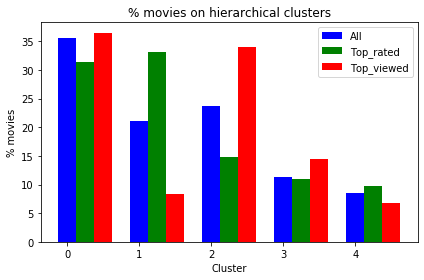

In [75]:
# data to plot
n_groups = 5

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8



rects1 = plt.bar(hier_clusters.hier_cluster, hier_clusters[('%_movies')], bar_width,
color='b',
label='All')

rects2 = plt.bar(hier_clusters.hier_cluster  + bar_width, hier_clusters[('%_top_rated_movies')], bar_width,
color='g',
label='Top_rated')

rects3 = plt.bar(hier_clusters.hier_cluster  + 2*bar_width, hier_clusters[('%_top_viewed_movies')], bar_width,
color='r',
label='Top_viewed')

plt.xlabel('Cluster')
plt.ylabel('% movies')
plt.title('% movies on hierarchical clusters')
plt.xticks(index , index)

plt.legend()
# ax.tick_params(labelsize=3)

plt.savefig('blog/04_clustering/02_Clusters_hier.png', format='png', dpi=2400);

plt.tight_layout()
plt.show()



Most of the movies (more than 30% of each category) are in cluster 0.

Clusters 0, 3 and 4 are balanced but number 1 has much more top rated movies and cluster 2 has top viewed movies as predominant

### <a class="anchor" id="Clust_general"> 3.b.- Clustering database with Gaussian Mixture Model Clustering

In this section we apply GMM Clustering to the dataframe. 

In [2]:
movies_pca_end = pd.read_csv('IMDB_movies_clasif_pca_end.csv')

**How do we initialize the algorithm?**

GMM algorithm is very sensible to the initialization state, that is determined by the hyperparameter of random_state. We are going to check different values for it for 5 clusters, and see which one gets better score

In [7]:
def get_sil_score(data, random):
    
    start_time = time.time()    
    
    gmm = mixture.GaussianMixture(n_components = 5, random_state = random)
    labels = gmm.fit_predict(data)

    score = silhouette_score(data, labels)
       

    exec_time = round((time.time() - start_time)/60,2)
    print("Execution time:",exec_time,"minutes")
    print("The silhouette score for",random,"random state and 5 components is", score)
    return score

In [8]:
scores = []
random = [10,20,30,40,50,99]

In [9]:
scores.append(get_sil_score(movies_pca_end, 10))

Execution time: 1.96 minutes
The silhouette score for 10 random state and 5 components is -0.005450687323295617


In [11]:
scores.append(get_sil_score(movies_pca_end, 30))

Execution time: 1.68 minutes
The silhouette score for 30 random state and 5 components is 0.07280535977985854


In [12]:
scores.append(get_sil_score(movies_pca_end, 40))

Execution time: 1.94 minutes
The silhouette score for 40 random state and 5 components is -0.006886661584911164


In [13]:
scores.append(get_sil_score(movies_pca_end, 50))

Execution time: 0.56 minutes
The silhouette score for 50 random state and 5 components is 0.14257509755353784


In [14]:
scores.append(get_sil_score(movies_pca_end, 99))

Execution time: 0.77 minutes
The silhouette score for 99 random state and 5 components is 0.0619386532588174


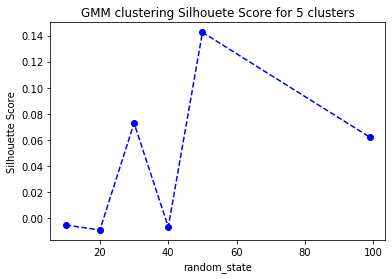

In [17]:
plt.plot(random, scores, linestyle='--', marker='o', color='b');
plt.xlabel('random_state');
plt.ylabel('Silhouette Score');
plt.title('GMM clustering Silhouete Score for 5 clusters');

Random state 50 is the best.

**How many clusters? The silhouette score**

Like in prior examples we will apply the silhouette score to different number of clusters to get the one with highest score, initializing the algorithm with random state 50

In [19]:
def get_sil_score(data, clusters):
    
    start_time = time.time()    
    
    gmm = mixture.GaussianMixture(n_components = clusters, random_state = 50)
    labels = gmm.fit_predict(data)

    score = silhouette_score(data, labels)
       

    exec_time = round((time.time() - start_time)/60,2)
    print("Execution time:",exec_time,"minutes")
    print("The silhouette score for",clusters,"components is", score)
    return score

In [20]:
scores = []
centers = [4, 5, 6, 7, 10]

In [21]:
scores.append(get_sil_score(movies_pca_end, 10))

Execution time: 3.13 minutes
The silhouette score for 10 components is -0.01898618004367647


In [22]:
scores.append(get_sil_score(movies_pca_end, 7))

Execution time: 2.25 minutes
The silhouette score for 7 components is 0.0024400960281790967


In [23]:
scores.append(get_sil_score(movies_pca_end, 6))

Execution time: 1.75 minutes
The silhouette score for 6 components is 0.10261369633523086


In [24]:
scores.append(get_sil_score(movies_pca_end, 4))

Execution time: 2.41 minutes
The silhouette score for 4 components is 0.07103744687002352


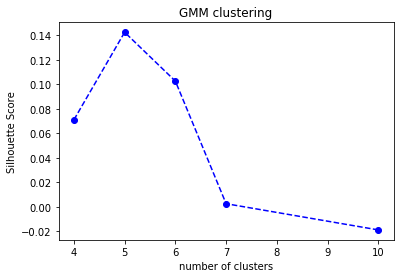

In [58]:
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('number of clusters');
plt.ylabel('Silhouette Score');
plt.title('GMM clustering');

5 clusters is the optimal number. Let´s fit the model with this k

**Fitting the model**

We fit the model with 5 clusters and random state 50

In [29]:
gmm = mixture.GaussianMixture(n_components = 5, random_state = 50)
labels = gmm.fit_predict(movies_pca_end)

In [30]:
silhouette_score(movies_pca_end, labels)

0.14257509755353784

Let´s analyze the labels predicted

In [31]:
# labels = model.predict(movies_pca_end)
labels_movies = pd.DataFrame(labels)
labels_movies.columns = ['gmm_cluster']

In [32]:
labels_movies.shape

(30321, 1)

Here you have the number of movies in each of the clusters

In [33]:
labels_movies.gmm_cluster.value_counts()/len(labels_movies)

3    0.348372
4    0.240394
2    0.228521
1    0.121797
0    0.060915
Name: gmm_cluster, dtype: float64

**Predicting clusters**

We get the cluster where each movie belongs to

In [34]:
movies_cluster = pd.read_csv('IMDB_movies_clustered.csv')

In [37]:
movies_cluster.head()

,originalTitle,Genres,Year,Minutes,director,actor,actress,writer,numVotes,averageRating,kmeans_cluster,hier_cluster
0,L'Inferno,"Adventure,Drama,Fantasy",1911,68,Francesco Bertolini,Salvatore Papa,Not available,Dante Alighieri,2167,7.0,57,1
1,Fantômas - À l'ombre de la guillotine,"Crime,Drama",1913,54,Louis Feuillade,René Navarre,Renée Carl,Marcel Allain,1915,7.0,59,1
2,Juve contre Fantômas,"Crime,Drama",1913,61,Louis Feuillade,René Navarre,Renée Carl,Marcel Allain,1334,7.0,59,1
3,Le mort qui tue,"Crime,Drama,Mystery",1913,90,Louis Feuillade,René Navarre,Not available,Marcel Allain,1033,7.0,8,1
4,Der Student von Prag,"Drama,Fantasy,Horror",1913,85,Stellan Rye,Paul Wegener,Grete Berger,Hanns Heinz Ewers,1735,6.5,10,1


In [38]:
labels_movies.head()

,gmm_cluster
0,2
1,2
2,2
3,2
4,2


In [39]:
movies_cluster.shape, labels_movies.shape

((30321, 12), (30321, 1))

In [40]:
movies_cluster = pd.merge(movies_cluster, labels_movies, left_index=True, right_index=True)

In [41]:
movies_cluster.head()

,originalTitle,Genres,Year,Minutes,director,actor,actress,writer,numVotes,averageRating,kmeans_cluster,hier_cluster,gmm_cluster
0,L'Inferno,"Adventure,Drama,Fantasy",1911,68,Francesco Bertolini,Salvatore Papa,Not available,Dante Alighieri,2167,7.0,57,1,2
1,Fantômas - À l'ombre de la guillotine,"Crime,Drama",1913,54,Louis Feuillade,René Navarre,Renée Carl,Marcel Allain,1915,7.0,59,1,2
2,Juve contre Fantômas,"Crime,Drama",1913,61,Louis Feuillade,René Navarre,Renée Carl,Marcel Allain,1334,7.0,59,1,2
3,Le mort qui tue,"Crime,Drama,Mystery",1913,90,Louis Feuillade,René Navarre,Not available,Marcel Allain,1033,7.0,8,1,2
4,Der Student von Prag,"Drama,Fantasy,Horror",1913,85,Stellan Rye,Paul Wegener,Grete Berger,Hanns Heinz Ewers,1735,6.5,10,1,2


In [42]:
movies_cluster.to_csv('IMDB_movies_clustered.csv', index = False)

**Analyzing clusters**

In GMM we can´t get a description of the clusters, just know which elements belong to each one

**Probabilities of belonging to a cluster**

One interesting thing is that GMM returns the probability that a data point belongs to each of the K clusters.

In [43]:
probs = gmm.predict_proba(movies_pca_end)

In [44]:
probs

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

**Create the most viewed and the top rated movies dataframes**

Let´s get the movies with percentile higher to 90% of most viewed and rated 

In [47]:
movies_cluster.numVotes.quantile(0.9)

54714.0

In [48]:
movies_cluster_views = movies_cluster[movies_cluster.numVotes > 54714]

In [49]:
movies_cluster.averageRating.quantile(0.9)

7.6

In [50]:
movies_cluster_rates = movies_cluster[movies_cluster.averageRating > 7.6]

In [51]:
movies_cluster.shape, movies_cluster_views.shape, movies_cluster_rates.shape

((30321, 13), (3032, 13), (2897, 13))

#### Comparing the three clusterizations

Now that we have clustered the three databases, we are going to compare the results.

Next, you can see the rate of movies belonging to each cluster for the three databases

In [52]:
gmm_clusters = movies_cluster.groupby(['gmm_cluster'])['originalTitle'].count() * 100 /len(movies_cluster)

In [53]:
gmm_clusters = gmm_clusters.to_frame().reset_index()
gmm_clusters.columns = ['gmm_cluster', "%_movies"]

In [54]:
gmm_clusters['%_top_rated_movies'] = movies_cluster_rates.groupby(['gmm_cluster'])['originalTitle'].count() * 100 /len(movies_cluster_rates)
gmm_clusters['%_top_viewed_movies'] = movies_cluster_views.groupby(['gmm_cluster'])['originalTitle'].count() * 100 /len(movies_cluster_views)

In [55]:
gmm_clusters

,gmm_cluster,%_movies,%_top_rated_movies,%_top_viewed_movies
0,0,6.091488,9.285468,2.440633
1,1,12.179677,11.529168,15.303430
2,2,22.852149,34.898171,11.444591
3,3,34.837242,27.131515,36.741425
4,4,24.039445,17.155678,34.069921


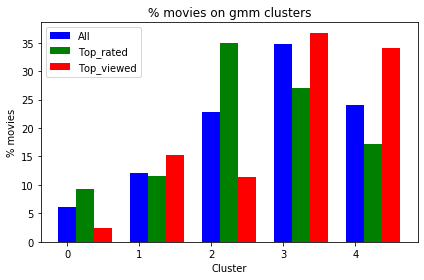

In [56]:
# data to plot
n_groups = 5

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8


rects1 = plt.bar(gmm_clusters.gmm_cluster, gmm_clusters[('%_movies')], bar_width,
color='b',
label='All')

rects2 = plt.bar(gmm_clusters.gmm_cluster  + bar_width, gmm_clusters[('%_top_rated_movies')], bar_width,
color='g',
label='Top_rated')

rects3 = plt.bar(gmm_clusters.gmm_cluster  + 2*bar_width, gmm_clusters[('%_top_viewed_movies')], bar_width,
color='r',
label='Top_viewed')

plt.xlabel('Cluster')
plt.ylabel('% movies')
plt.title('% movies on gmm clusters')
plt.xticks(index , index)

plt.legend()
# ax.tick_params(labelsize=3)

plt.savefig('blog/04_clustering/02_Clusters_gmm.png', format='png', dpi=2400);

plt.tight_layout()
plt.show()

### <a class="anchor" id="Compare_1"> 3.c.- Comparing hierarchical and GMM results
    
The results are really similar

In [59]:
movies_cluster.head()

,originalTitle,Genres,Year,Minutes,director,actor,actress,writer,numVotes,averageRating,kmeans_cluster,hier_cluster,gmm_cluster
0,L'Inferno,"Adventure,Drama,Fantasy",1911,68,Francesco Bertolini,Salvatore Papa,Not available,Dante Alighieri,2167,7.0,57,1,2
1,Fantômas - À l'ombre de la guillotine,"Crime,Drama",1913,54,Louis Feuillade,René Navarre,Renée Carl,Marcel Allain,1915,7.0,59,1,2
2,Juve contre Fantômas,"Crime,Drama",1913,61,Louis Feuillade,René Navarre,Renée Carl,Marcel Allain,1334,7.0,59,1,2
3,Le mort qui tue,"Crime,Drama,Mystery",1913,90,Louis Feuillade,René Navarre,Not available,Marcel Allain,1033,7.0,8,1,2
4,Der Student von Prag,"Drama,Fantasy,Horror",1913,85,Stellan Rye,Paul Wegener,Grete Berger,Hanns Heinz Ewers,1735,6.5,10,1,2


In [70]:
clusters_comp = movies_cluster.groupby(['hier_cluster','gmm_cluster'])['originalTitle'].count().to_frame().reset_index()
clusters_comp.columns =['hier_cluster','gmm_cluster','n_movies']

In [71]:
clusters_comp

,hier_cluster,gmm_cluster,n_movies
0,0,0,18
1,0,1,48
2,0,2,50
3,0,3,10503
4,0,4,166
5,1,0,1815
6,1,1,251
7,1,2,4321
8,1,3,1
9,1,4,3


In [95]:
# cluster 0 in hierarchical clustering
clusters_comp_0 = clusters_comp[clusters_comp.hier_cluster == 0]
n_0 = np.sum(clusters_comp_0.n_movies)
clusters_comp_0['%_movies'] = round(clusters_comp_0['n_movies'] * 100 /n_0,2)
clusters_comp_0 = clusters_comp_0.drop(['n_movies'], axis=1)

# cluster 1 in hierarchical clustering
clusters_comp_1 = clusters_comp[clusters_comp.hier_cluster == 1]
n_1 = np.sum(clusters_comp_1.n_movies)
clusters_comp_1['%_movies'] = round(clusters_comp_1['n_movies'] * 100 /n_1,2)
clusters_comp_1 = clusters_comp_1.drop(['n_movies'], axis=1)

# cluster 2 in hierarchical clustering
clusters_comp_2 = clusters_comp[clusters_comp.hier_cluster == 2]
n_2 = np.sum(clusters_comp_2.n_movies)
clusters_comp_2['%_movies'] = round(clusters_comp_2['n_movies'] * 100 /n_2,2)
clusters_comp_2 = clusters_comp_2.drop(['n_movies'], axis=1)

# cluster 3 in hierarchical clustering
clusters_comp_3 = clusters_comp[clusters_comp.hier_cluster == 3]
n_3 = np.sum(clusters_comp_3.n_movies)
clusters_comp_3['%_movies'] = round(clusters_comp_3['n_movies'] * 100 /n_3,3)
clusters_comp_3 = clusters_comp_3.drop(['n_movies'], axis=1)

# cluster 4 in hierarchical clustering
clusters_comp_4 = clusters_comp[clusters_comp.hier_cluster == 4]
n_4 = np.sum(clusters_comp_4.n_movies)
clusters_comp_4['%_movies'] = round(clusters_comp_4['n_movies'] * 100 /n_4,3)
clusters_comp_4 = clusters_comp_4.drop(['n_movies'], axis=1)


C:\Users\cance\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\cance\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\cance\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [127]:
clusters_comp_1

,hier_cluster,gmm_cluster,%_movies
5,1,0,28.40
6,1,1,3.93
7,1,2,67.61
8,1,3,0.02
9,1,4,0.05


Text(0.5, 1.0, 'Hierarchical cluster 4')

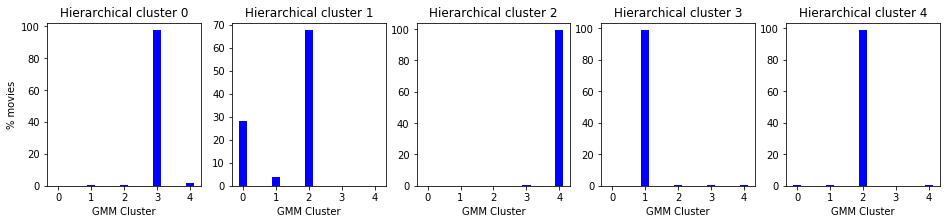

In [126]:
plt.figure(figsize = [16, 3])

bar_width = 0.25
opacity = 0.8
index = [0,1,2,3,4]

plt.subplot(1, 5, 1)
plt.bar(clusters_comp_0.gmm_cluster, clusters_comp_0[('%_movies')], bar_width, color='b', label='All');
plt.xlabel('GMM Cluster')
plt.ylabel('% movies')
plt.xticks(index , index)
plt.title('Hierarchical cluster 0')

plt.subplot(1, 5, 2)
plt.bar(clusters_comp_1.gmm_cluster, clusters_comp_1[('%_movies')], bar_width, color='b', label='All');
plt.xlabel('GMM Cluster')
plt.xticks(index , index)
plt.title('Hierarchical cluster 1')

plt.subplot(1, 5, 3)
plt.bar(clusters_comp_2.gmm_cluster, clusters_comp_2[('%_movies')], bar_width, color='b', label='All');
plt.xlabel('GMM Cluster')
plt.xticks(index , index)
plt.title('Hierarchical cluster 2')

plt.subplot(1, 5, 4)
plt.bar(clusters_comp_3.gmm_cluster, clusters_comp_3[('%_movies')], bar_width, color='b', label='All');
plt.xlabel('GMM Cluster')
plt.xticks(index , index)
plt.title('Hierarchical cluster 3')

plt.subplot(1, 5, 5)
plt.bar(clusters_comp_4.gmm_cluster, clusters_comp_4[('%_movies')], bar_width, color='b', label='All');
plt.xlabel('GMM Cluster')
plt.xticks(index , index)
plt.title('Hierarchical cluster 4')
